# Adaptative Impedance Controller 

Install the python libraries

In [ ]:
from IPython.display import clear_output
from IPython.display import Image


In [ ]:
Image(filename='pictures/anacondapromt.png')

In [1]:
import time
import serial         #conda install -c anaconda pyserial
import numpy as np    #conda install -c anaconda numpy
import numpy.linalg as la
from datetime import datetime
import math
import json          #conda install -c jmcmurray json  
from scipy import stats  #conda install -c anaconda scipy
import matplotlib.pyplot as plt  #conda install -c conda-forge matplotlib

***
$\mathbf{\text{Basic Control Functions}}$<br>
***

In [ ]:
Image(filename='pictures/pneumaticsystem.png')

In [ ]:
def star_communication(port):
    ser = serial.Serial(port, 115200, timeout=1)   #Include the number of the serial port
    return ser
    
def close_communication(ser):
    motor_control(ser,1)
    ser.close()


def read_data(ser):
    #ser_bytes = ser.readline()
    ser.flushInput()
    
    cmd='r'+'120'+'\n'
    ser.write(bytes(cmd, encoding='ascii'))
    
    time.sleep(0.015)
    ser_bytes = ser.readline(ser.inWaiting())
    decoded_bytes = ser_bytes.decode()
    if len(decoded_bytes)>0 :
        decoded_bytes=decoded_bytes.strip()
        separated_data=decoded_bytes.split(",")
        if len(separated_data[0])>=4:
            integer_data = [i for i in separated_data]
            integer_array= np.array(integer_data)
        else:
            integer_array=np.zeros(5)
            integer_array[0]=2000
    else:
        integer_array=np.zeros(5)
        integer_array[0]=2000
    return integer_array

    
def feedback_data(ser):              #current angle, current pressure, set_point(pressure or angle controller depends of the control), motor_speed
    integer_array=read_data(ser)
    while len(integer_array)<5 or integer_array[0]==2000:
        integer_array=read_data(ser)
    integer_array2=integer_array
    return integer_array2




In [ ]:
Image(filename='pictures/pid.png')

In [ ]:
Image(filename='pictures/pid_response.png')

In [3]:
def motor_control(ser, speed_val):    #speed on the range of +255 to -255, Negative values just open the valve and stop the pump, 0 stops the pump but valve is still working
    ser_bytes = ser.readline()
    ser.flushInput()
    time.sleep(0.001)
    motor_speed=str(speed_val)
    cmd='m'+motor_speed+'\n'
    print(cmd)
    ser.write(bytes(cmd, encoding='ascii'))

def pressure_control(ser, pressure_val):    #pressure on the range of 0 to +25 kpa
    ser_bytes = ser.readline()
    ser.flushInput()
    time.sleep(0.001)
    motor_pressure=str(pressure_val)
    cmd='p'+motor_pressure+'\n'
    #print(cmd)
    ser.write(bytes(cmd, encoding='ascii'))
    
def bend_control(ser, bend_val):    #angle on the range of 0 to +180
    ser_bytes = ser.readline()
    ser.flushInput()
    time.sleep(0.001)
    motor_bend=str(bend_val)
    cmd='a'+motor_bend+'\n'
    #print(cmd)
    ser.write(bytes(cmd, encoding='ascii'))


1.&emsp;Demo code for control functions usage <br>

In [ ]:
ser=star_communication('COM14')
motor_control(ser,50)        #Activating speed control with setpoint at 50
time.sleep(5)
pressure_control(ser, 22)    #Activating pressure control with setpoint at 22
time.sleep(5)
bend_control(ser, 90)        #Activating angle control with setpoint at 90
time.sleep(5)
values=feedback_data(ser)    #Getting data from microcontroller
time.sleep(0.1)
print(values)
values=feedback_data(ser)
time.sleep(0.1)
print(values)
close_communication(ser)

In [31]:
ser=star_communication('COM14')
time.sleep(2)
motor_control(ser,-10)
time.sleep(1)
ser.close()

m-10



2.&emsp;Demo code for simple close loop control <br>

In [39]:
i=0
ser=star_communication('COM14')
values=feedback_data(ser)
bend_control(ser, 120)
while (i<1000):                     # Close loop controller
    #bend_control(ser, 120)
    time.sleep(0.1)
    values=feedback_data(ser)
    print(str(i)+' '+str(values))
    i=i+1
values=feedback_data(ser)
print(str(i)+' '+str(values))
close_communication(ser)

0 ['-1.81' '17.36' '0.00' '0' '']
1 ['-1.81' '17.47' '120.00' '255' '']
2 ['-0.18' '18.67' '0.00' '11' '']
3 ['-0.18' '18.45' '0.00' '9' '']
4 ['-0.18' '18.45' '0.00' '17' '']
5 ['-0.18' '18.34' '0.00' '17' '']
6 ['-0.18' '18.45' '0.00' '17' '']
7 ['-0.18' '18.34' '0.00' '17' '']
8 ['-0.18' '18.34' '0.00' '17' '']
9 ['-0.18' '18.34' '0.00' '17' '']
10 ['-0.18' '18.34' '0.00' '17' '']
11 ['-0.18' '18.34' '0.00' '17' '']
12 ['-0.18' '18.34' '0.00' '17' '']
13 ['-0.18' '18.34' '0.00' '17' '']
14 ['-0.18' '18.23' '0.00' '17' '']
15 ['-0.18' '18.34' '0.00' '17' '']
16 ['-0.18' '18.23' '0.00' '18' '']
17 ['-0.18' '18.23' '0.00' '18' '']
18 ['-0.18' '18.23' '0.00' '18' '']
19 ['-0.18' '18.23' '0.00' '18' '']
20 ['-0.18' '18.23' '0.00' '18' '']
21 ['-0.18' '18.23' '0.00' '18' '']
22 ['-0.18' '18.23' '0.00' '18' '']
23 ['-0.18' '18.23' '0.00' '18' '']
24 ['-0.18' '18.23' '0.00' '18' '']
25 ['-0.18' '18.23' '0.00' '18' '']
26 ['-0.18' '18.23' '0.00' '18' '']
27 ['-0.18' '18.23' '0.00' '18' '']
2

225 ['-0.17' '19.21' '0.00' '24' '']
226 ['-0.17' '19.21' '0.00' '24' '']
227 ['-0.17' '19.43' '0.00' '24' '']
228 ['-0.17' '19.32' '0.00' '24' '']
229 ['-0.17' '19.32' '0.00' '24' '']
230 ['-0.17' '19.32' '0.00' '24' '']
231 ['-0.17' '19.32' '0.00' '24' '']
232 ['-0.17' '19.32' '0.00' '24' '']
233 ['-0.17' '19.32' '0.00' '25' '']
234 ['-0.17' '19.43' '0.00' '25' '']
235 ['-0.17' '19.43' '0.00' '25' '']
236 ['-0.17' '19.43' '0.00' '25' '']
237 ['-0.17' '19.43' '0.00' '25' '']
238 ['-0.17' '19.32' '0.00' '25' '']
239 ['-0.17' '19.43' '0.00' '25' '']
240 ['-0.17' '19.32' '0.00' '25' '']
241 ['-0.17' '19.43' '0.00' '25' '']
242 ['-0.17' '19.43' '0.00' '25' '']
243 ['-0.17' '19.54' '0.00' '25' '']
244 ['-0.17' '19.43' '0.00' '25' '']
245 ['-0.17' '19.43' '0.00' '25' '']
246 ['-0.17' '19.43' '0.00' '25' '']
247 ['-0.17' '19.43' '0.00' '25' '']
248 ['-0.17' '19.43' '0.00' '25' '']
249 ['-0.17' '19.65' '0.00' '25' '']
250 ['-0.17' '19.54' '0.00' '25' '']
251 ['-0.17' '19.54' '0.00' '25' '']
2

447 ['-0.17' '21.83' '0.00' '29' '']
448 ['-0.17' '21.83' '0.00' '29' '']
449 ['-0.17' '21.94' '0.00' '29' '']
450 ['-0.17' '21.94' '0.00' '29' '']
451 ['-0.17' '21.94' '0.00' '30' '']
452 ['-0.17' '21.94' '0.00' '30' '']
453 ['-0.17' '21.94' '0.00' '30' '']
454 ['-0.17' '21.94' '0.00' '30' '']
455 ['-0.17' '22.05' '0.00' '30' '']
456 ['-0.17' '22.05' '0.00' '30' '']
457 ['-0.17' '22.05' '0.00' '30' '']
458 ['-0.17' '21.94' '0.00' '30' '']
459 ['-0.17' '21.94' '0.00' '30' '']
460 ['-0.17' '22.05' '0.00' '30' '']
461 ['-0.17' '22.05' '0.00' '30' '']
462 ['-0.17' '21.94' '0.00' '30' '']
463 ['-0.17' '21.94' '0.00' '30' '']
464 ['-0.17' '21.94' '0.00' '30' '']
465 ['-0.17' '22.05' '0.00' '30' '']
466 ['-0.17' '22.05' '0.00' '30' '']
467 ['-0.17' '22.05' '0.00' '30' '']
468 ['-0.17' '22.05' '0.00' '30' '']
469 ['-0.17' '22.05' '0.00' '30' '']
470 ['-0.17' '22.05' '0.00' '30' '']
471 ['-0.17' '22.16' '0.00' '30' '']
472 ['-0.17' '22.16' '0.00' '30' '']
473 ['-0.17' '22.05' '0.00' '30' '']
4

669 ['-0.17' '23.46' '0.00' '34' '']
670 ['-0.17' '23.46' '0.00' '34' '']
671 ['-0.17' '23.46' '0.00' '34' '']
672 ['-0.17' '23.46' '0.00' '35' '']
673 ['-0.17' '23.57' '0.00' '35' '']
674 ['-0.17' '23.46' '0.00' '35' '']
675 ['-0.17' '23.46' '0.00' '35' '']
676 ['-0.17' '23.46' '0.00' '35' '']
677 ['-0.17' '23.46' '0.00' '35' '']
678 ['-0.17' '23.46' '0.00' '35' '']
679 ['-0.17' '23.46' '0.00' '35' '']
680 ['-0.17' '23.46' '0.00' '35' '']
681 ['-0.17' '23.46' '0.00' '35' '']
682 ['-0.17' '23.46' '0.00' '35' '']
683 ['-0.17' '23.57' '0.00' '35' '']
684 ['-0.17' '23.46' '0.00' '35' '']
685 ['-0.17' '23.57' '0.00' '35' '']
686 ['-0.17' '23.57' '0.00' '35' '']
687 ['-0.17' '23.57' '0.00' '35' '']
688 ['-0.17' '23.57' '0.00' '35' '']
689 ['-0.17' '23.68' '0.00' '35' '']
690 ['-0.17' '23.57' '0.00' '35' '']
691 ['-0.17' '23.68' '0.00' '35' '']
692 ['-0.17' '23.68' '0.00' '35' '']
693 ['-0.17' '23.68' '0.00' '35' '']
694 ['-0.17' '23.79' '0.00' '35' '']
695 ['-0.17' '23.68' '0.00' '35' '']
6

891 ['-0.17' '23.68' '0.00' '39' '']
892 ['-0.17' '23.68' '0.00' '39' '']
893 ['-0.17' '23.68' '0.00' '40' '']
894 ['-0.17' '23.57' '0.00' '40' '']
895 ['-0.17' '23.79' '0.00' '40' '']
896 ['-0.17' '23.90' '0.00' '40' '']
897 ['-0.17' '23.68' '0.00' '40' '']
898 ['-0.17' '23.57' '0.00' '40' '']
899 ['-0.17' '23.57' '0.00' '40' '']
900 ['-0.17' '23.57' '0.00' '40' '']
901 ['-0.17' '23.90' '0.00' '40' '']
902 ['-0.17' '23.57' '0.00' '40' '']
903 ['-0.17' '23.68' '0.00' '40' '']
904 ['-0.17' '23.68' '0.00' '40' '']
905 ['-0.17' '23.90' '0.00' '40' '']
906 ['-0.17' '23.68' '0.00' '40' '']
907 ['-0.17' '23.68' '0.00' '40' '']
908 ['-0.17' '23.68' '0.00' '40' '']
909 ['-0.17' '23.68' '0.00' '40' '']
910 ['-0.17' '24.01' '0.00' '40' '']
911 ['-0.17' '23.68' '0.00' '40' '']
912 ['-0.17' '23.57' '0.00' '40' '']
913 ['-0.17' '23.68' '0.00' '40' '']
914 ['-0.17' '23.68' '0.00' '40' '']
915 ['-0.17' '23.90' '0.00' '40' '']
916 ['-0.17' '23.57' '0.00' '40' '']
917 ['-0.17' '23.79' '0.00' '40' '']
9

In [ ]:
ser=star_communication('COM14')
time.sleep(2)
motor_control(ser,-10)
time.sleep(1)
ser.close()

***
$\mathbf{\text{Zero-torque Trajectory}}$<br>
***
1.&emsp;The zero-torque trajectory of the controller, $q_{d}(t)$ followed a minimum-jerk trajectory <br>

$$q_{d}(t) = q_{i} + (q_{f} - q_{i}) \Bigg[ 10 (\frac{t}{D})^3 - 15 (\frac{t}{D})^4 + 6 (\frac{t}{D})^5 \Bigg]   (4)$$

**Cite**: Equation (4) at Xiong, X., Nah, M. C., Krotov, A., & Sternad, D. (Accepted/In press). Online Impedance Adaptation Facilitates Manipulating a Whip. In Proceedings of the International Conference on Intelligent Robots and Systems (IROS 2021) IEEE.[Link](https://github.com/Jonasjcmh/PneuNet_Controller/blob/main/References/IROS21_1612_MS.pdf)

**Task**: Complete the function des_tra(self, t, dt), based on the equation 4 and the input parameters $q_{i}=$self.ini_ang, $q_{f}=$self.end_ang, $D=$self.dur <br>
**Use the function np.power(value,exponent)<br>

In [ ]:
Image(filename='pictures/minimal_jerk.png')

In [ ]:
def des_tra(self, t, dt):   ####Trajectory planner### minimum jerk trajectory equation 4 iros2021
        
        
        des_ang =  .....................
        
        deg_vel = (des_ang - self.pre_ang)/dt
        self.pre_ang = np.copy(des_ang)
        return des_ang, deg_vel

***
$\mathbf{\text{Adaptative Motor Controller}}$<br>
***

In [ ]:
Image(filename='pictures/acm.png')

1.&emsp;The position error $e(t)$, velocity error $\dot{e}(t)$, and tracking error $\varepsilon(t)$ are given by:  <br>

$$e(t)=q(t)-q_{d}(t)$$
$$\dot{e}(t)=\dot{q}(t)-\dot{q}_{d}(t)$$
$$\varepsilon(t)=e(t)+\beta\dot{e}(t)$$

**Cite**: Equation (3) at X. Xiong and P. Manoonpong, "Adaptive Motor Control for Human-like Spatial-temporal Adaptation," 2018 IEEE International Conference on Robotics and Biomimetics (ROBIO), 2018, pp. 2107-2112, doi: 10.1109/ROBIO.2018.8665222. [Link](https://github.com/Jonasjcmh/PneuNet_Controller/blob/main/References/root.pdf)

**Task**: Complete the function gen_vel_err(self), gen_track_err(self), based on the equation 3 and the input parameters $q=$self.q, $\dot{q}(t)=$self.dq, <br>
$\dot{q}_{d}(t)=$self.dq_d, $\beta=$self.k


In [ ]:
def gen_pos_err(self):   ## 2018 equ. 3
        #print np.mat(self.arm.q).shape, self.task.ref_traj_ang.shape
        return (self.q - self.q_d)

def gen_vel_err(self):   ## 2018 equ. 3
        #print np.mat(self.arm.dq).shape, self.task.ref_traj_vel.shape
        return (................)

def gen_track_err(self):  ## 2018 equ. 3
        return (................)

2.&emsp;$\gamma(t)$ is an adaptation scalar with the positive scalrs $a$ and $b$, defined as follows:  <br>

$$\gamma(t)=\frac{a}{1+b \mid\mid \varepsilon(t) \mid\mid^2 }$$


**Cite**: Equation (9) at X. Xiong and P. Manoonpong, "Adaptive Motor Control for Human-like Spatial-temporal Adaptation," 2018 IEEE International Conference on Robotics and Biomimetics (ROBIO), 2018, pp. 2107-2112, doi: 10.1109/ROBIO.2018.8665222. [Link](https://github.com/Jonasjcmh/PneuNet_Controller/blob/main/References/root.pdf)

**Task**: Complete the function gen_for_factor(self), based on the equation 9 and the input parameters $a=$self.a, $b=$self.b, and $\varepsilon(t)=$gen_track_err()<br>

To calculate the norm of the equation you can use the function la.norm()<br>


In [ ]:
def gen_for_factor(self):  ## 2018 equ. 9  adaptation rate
        return ................)

3.&emsp;The force and impedance adaptation is guided by: <br>

$$F(t)=\frac{\varepsilon(t)}{\gamma(t)}$$ <br>
$$K(t)=F(t)e^T(t)$$  <br>
$$D(t)=F(t)\dot{e}^T(t)$$ <br>



**Cite**: Equation (8) at X. Xiong and P. Manoonpong, "Adaptive Motor Control for Human-like Spatial-temporal Adaptation," 2018 IEEE International Conference on Robotics and Biomimetics (ROBIO), 2018, pp. 2107-2112, doi: 10.1109/ROBIO.2018.8665222. [Link](https://github.com/Jonasjcmh/PneuNet_Controller/blob/main/References/root.pdf)

**Task**: Complete the function update_impedance(self, q, q_d, dq, dq_d), based on the equation 8 and the input parameters <br>
$\varepsilon(t)=$gen_track_err(), <br>
$\gamma(t)=$gen_for_factor(), <br>
$e=$gen_pos_err(), <br>
$\dot{e}=$gen_vel_err().  <br>

**To calculate the transposed matrix of the vector you can use the function ndarray.T(), e.g. $e^T(t)=$self.gen_pos_err().T<br>

In [ ]:
def update_impedance(self, q, q_d, dq, dq_d):   ### main function for impedance control equation 8 and 9 in 2018 paper

        self.q = np.mat(np.copy(q)).T
        self.q_d = np.mat(np.copy(q_d)).T

        self.dq = np.mat(np.copy(dq)).T
        self.dq_d = np.mat(np.copy(dq_d)).T

        self.k_mat = ..................         #stiffness

        self.d_mat = ..................         # damping

        self.ff_tau_mat = self.gen_track_err() / self.gen_for_factor()

        return self.k_mat, self.d_mat, self.ff_tau_mat


***
$\mathbf{\text{Adaptative impedance controller Class}}$<br>
***

In [ ]:
class ada_imp_con( ):
    def __init__(self, dof):
        self.DOF = dof
        self.k_mat = np.mat(np.zeros((self.DOF, self.DOF)))
        self.d_mat = np.mat(np.zeros((self.DOF, self.DOF)))
        self.ff_tau_mat = np.mat(np.zeros((self.DOF, 1)))

        self.q = np.mat(np.zeros((self.DOF, 1)))
        self.q_d = np.mat(np.zeros((self.DOF, 1)))

        self.dq = np.mat(np.zeros((self.DOF, 1)))
        self.dq_d = np.mat(np.zeros((self.DOF, 1)))
        self.a = 0.2
        self.b = 44000.0#35000.0#5.0
        self.k = 0.05#

        #minimal jerk trajectory
        self.ini_ang = 0.0   #q_i
        self.end_ang = 60.0  #q_f
        self.dur = 2.0       #D
        self.pre_ang = 0.0
        
        
    def des_tra(self, t, dt):   ####Trajectory planner### minimum jerk trajectory equation 4 iros2021
        des_ang = self.ini_ang + ( self.end_ang - self.ini_ang ) * ( 10 * np.power(t,3 ) / ( self.dur ** 3 ) - 15 * np.power(t, 4 ) / ( self.dur ** 4 ) +  6 * np.power( t, 5 ) / ( self.dur ** 5 ) )
        deg_vel = (des_ang - self.pre_ang)/dt
        self.pre_ang = np.copy(des_ang)
        return des_ang, deg_vel
    
    
    def gen_pos_err(self):   ## 2018 equ. 3
      ##Complete ###

    def gen_vel_err(self):   ## 2018 equ. 3
      ##Complete ###

    def gen_track_err(self):  ## 2018 equ. 3
      ##Complete ###

    def gen_for_factor(self):  ## 2018 equ. 9  adaptation rate
      ##Complete ###
    
    def update_impedance(self, q, q_d, dq, dq_d):   ### main function for impedance control equation 8 and 9 in 2018 paper
        self.q = np.mat(np.copy(q)).T
        self.q_d = np.mat(np.copy(q_d)).T
        self.dq = np.mat(np.copy(dq)).T
        self.dq_d = np.mat(np.copy(dq_d)).T

        self.k_mat = ##Complete ###

        self.d_mat = ##Complete ###

        self.ff_tau_mat = self.gen_track_err() / self.gen_for_factor()
        
        return self.k_mat, self.d_mat, self.ff_tau_mat



In [ ]:
# %load scripts/ada_imp_con.py

***
$\mathbf{\text{Demo version: Control loop for soft actuator}}$<br>
***

Initial parameters

In [ ]:
ser=star_communication('COM14')

n_t=0.0                           ## runing time
duration = 30                     ## total process time
pre_t = 0.0                       ##previous time n-1
DOF = 1                           ## control degrees of freedom

ada = ada_imp_con(DOF)            ##initialization of the adaptative function

ada.end_ang = 120.0               ## maximal point to reach
ada = ada_imp_con(DOF)            ##initialization of the adaptative function
ada.dur = duration                ##duration of the whole trajectory


motor_control(ser,1)              ##enough time for start the pump
time.sleep(5)                     ##enough time for start the pump
motor_val = 0.0                   ##control output to the pump
max_mo_val = 250                  ## saturation value
fb_motor_val = 0.                 ##feedback of the motor speed


values=feedback_data(ser)        ##getting initial position of the robot
in_ang = float(values[0])        ##getting initial position of the robot
now_ang = np.copy(in_ang)        ##getting initial position of the robot
pre_ang = np.copy(in_ang)        ##getting initial position of the robot
now_vel = 0.0                    ##getting initial position of the robot

alp= 0.9                         ##low-pass filter with a low bias from the input constant
ave_ang_err = 0.0                ## angular error angle-desired angle
t_s = 0                          ## sample time
s_t = datetime.now()             ##current initial time

1.&emsp;The $\tau(t)$ produced by the AMC includes the force and impedance parts: <br>

$$\tau(t) = -F(t)-K(t)e(t)-D(t)\dot{e}(t)   (2)$$

**Cite**: Equation (2) at Xiong, X., Nah, M. C., Krotov, A., & Sternad, D. (Accepted/In press). Online Impedance Adaptation Facilitates Manipulating a Whip. In Proceedings of the International Conference on Intelligent Robots and Systems (IROS 2021) IEEE. [Link](https://github.com/Jonasjcmh/PneuNet_Controller/blob/main/References/root.pdf)

**Task**: Complete the calculation of $\tau(t)=$fb_motor_val, based on the equation 2 and the input parameters $-K=$k[0,0], $-D=$d[0,0],the error and velocity error are calculated based on the current angle (now_ang_rad), desired angle (des_ang_rad), current velocity (now_vel_rad), and desired velocity (des_vel_rad).<br>
** e=des_ang_rad-now_ang_rad, F(t) = 0, 

In [ ]:
while (n_t < duration ):

    diff_t = datetime.now() - s_t
    n_t = diff_t.seconds + diff_t.microseconds/1E6               ##current process time

    dt = n_t-pre_t                                               ## time for 1 iteration

    des_ang, des_vel = ada.des_tra(n_t, dt)                      ##etting the desired trajectory 
    des_ang = in_ang + des_ang                                   ##initial position compensation (translation pos)

    values=feedback_data(ser)

    now_ang = float(values[0])                                  ##transforming to float value
    now_ang = (alp * pre_ang) + (1.0-alp) * (now_ang)           ##low pass filter 
    if (dt > 0.0):                                              ##avoid undefinition
        now_vel = (now_ang - pre_ang)/dt                        ##calculating the current speed 
    else:
        now_vel = 0.0

    
    now_ang_rad = (now_ang/180.0)*math.pi   ##transforming in radians units  current angle
    des_ang_rad = (des_ang/180.0)*math.pi   ##transforming in radians units  desired angle
    now_vel_rad = (now_vel/180.0)*math.pi   ##transforming in radians units  current speed
    des_vel_rad = (des_vel/180.0)*math.pi   ##transforming in radians units  desired speed
    
    k, d, ff = ada.update_impedance(now_ang_rad, des_ang_rad, now_vel_rad, des_vel_rad)     ##k stifness  d damping  ff not used
    
    fb_motor_val = ###Complete .....###  ##equation 2 2018
    
    print(n_t, des_ang_rad-now_ang_rad)                                                     ##fb_motor_val, k[0,0], d[0,0])#des_ang_rad-now_ang_rad)
    ave_ang_err = ave_ang_err + abs(des_ang_rad-now_ang_rad)                                ##acumulated average error


   
    motor_val = des_ang * 2.5                     ##  feed forward control with constant a=2.5
    motor_val = motor_val + fb_motor_val          ##  feedback control + ff control

    if motor_val > max_mo_val:                    ##  saturation of the motor speed
        motor_val = max_mo_val
        print('out of limit!')
        #break
    motor_control(ser,motor_val)                 ##   asigning the value to the board
    #print(motor_val, fb_motor_val)
    #print(n_t, motor_val, des_ang, des_vel)

    #print(values)
    #print(dt)
    t_s = t_s + 1


    pre_t = np.copy(n_t)                         ##     saving the previous values for time
    pre_ang = np.copy(now_ang)                   ##     saving the previous values for angle

print(ave_ang_err/t_s)                           ##     average error
close_communication(ser)

In [ ]:
# %load scripts/acm_control.py

In [11]:
ser=star_communication('COM14')
time.sleep(2)
motor_control(ser,-10)
time.sleep(1)
ser.close()

m-10



***
$\mathbf{\text{Sigmoid Function Estimation}}$<br>
***

In [4]:
import numpy as np
import pylab
from scipy.optimize import curve_fit
import pandas as pd
from scipy import signal
import csv

import pandas as pd
from scipy import signal
import csv

In [5]:
def sigmoid(x, x0, k):
     y = 1 / (1 + np.exp(-k*(x-x0)))
     return y

In [6]:
Image(filename='pictures/sigmoid.png')

NameError: name 'Image' is not defined

**Data set collection**

In [ ]:
i=0
ser=star_communication('COM14')
bend_control(ser, 180)
values=feedback_data(ser)
with open("Dataset/dataset6.csv","a") as f:
            writer = csv.writer(f,delimiter=";",lineterminator='\r')
            writer.writerow(['time','angle','pressure','set_point','motor_speed'])
            
while (i<600):                      # Close loop controller
    to=time.perf_counter()
    bend_control(ser, 180)
    time.sleep(0.001)
    values=feedback_data(ser)
    with open("Dataset/dataset6.csv","a") as f:
                        writer = csv.writer(f,delimiter=";",lineterminator='\r')
                        writer.writerow([time.perf_counter()-to,values[0],values[1],values[2], values[3]])
    #print(str(i)+' '+str(values))
    i=i+1
close_communication(ser)

ser=star_communication('COM14')
time.sleep(2)
motor_control(ser,-10)
time.sleep(1)
ser.close()

**Data processing**

In [7]:
with open(".csv","a") as f:
    df = pd.read_csv("Dataset/dataset6.csv",delimiter=';')
    #Filtering
    b, a = signal.butter(3, 0.05)
    filter_presure = signal.filtfilt(b, a, df['pressure'])
    df = df.assign(Filtered_Force=filter_presure)
    f.close()
    

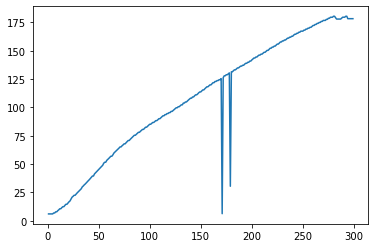

In [8]:
ydata=df['pressure']
xdata=df['angle']
ydata=ydata[1:300]/27
xdata=xdata[1:300]
pylab.plot(xdata, label='data')

In [ ]:
pylab.plot(ydata, label='data')

In [ ]:
popt, pcov = curve_fit(sigmoid, xdata, ydata)
print (popt)

#x = np.linspace(-1, 15, 50)
x=xdata
y = sigmoid(x, *popt)

pylab.plot(xdata, 27*ydata, 'o', label='data')
pylab.plot(x,27*y, label='fit')
#pylab.ylim(0, 1.05)
pylab.legend(loc='best')
pylab.show()

In [ ]:
xdata = np.array([0.0,   1.0,  3.0, 4.3, 7.0,   8.0,   8.5, 10.0, 12.0])
ydata = np.array([0.01, 0.02, 0.04, 0.11, 0.43,  0.7, 0.89, 0.95, 0.99])

In [ ]:
popt, pcov = curve_fit(sigmoid, xdata, ydata)
print (popt)

#x = np.linspace(-1, 15, 50)
x=xdata
y = sigmoid(x, *popt)

pylab.plot(xdata, ydata, 'o', label='data')
pylab.plot(x,y, label='fit')
pylab.ylim(0, 1.05)
pylab.legend(loc='best')
pylab.show()

In [12]:
i=0
j=0
degree=0
ser=star_communication('COM14')
bend_control(ser, 10)
values=feedback_data(ser)
to=time.perf_counter()
print('start')
with open("Dataset/dataset14.csv","a") as f:
            writer = csv.writer(f,delimiter=";",lineterminator='\r')
            writer.writerow(['time','angle','pressure','set_point','motor_speed'])
            
while (i<2000):                      # Close loop controller
    j=j+1
    if j==400 and degree <= 180:
        degree=degree+30
        bend_control(ser, degree)
        j=0
    
    time.sleep(0.02)
    values=feedback_data(ser)
    with open("Dataset/dataset14.csv","a") as f:
                        writer = csv.writer(f,delimiter=";",lineterminator='\r')
                        writer.writerow([time.perf_counter()-to,values[0],values[1],values[2], values[3]])
    print(str(i)+' '+str(values))
    i=i+1
close_communication(ser)

ser=star_communication('COM14')
time.sleep(2)
motor_control(ser,-10)
time.sleep(2)
ser.close()

start
0 ['-2.90' '6.13' '0.00' '0' '']
1 ['-2.90' '6.13' '0.00' '0' '']
2 ['-1.81' '6.24' '0.00' '0' '']
3 ['-2.64' '6.24' '0.00' '0' '']
4 ['-2.64' '6.24' '0.00' '0' '']
5 ['-4.11' '6.24' '0.00' '0' '']
6 ['-3.31' '6.35' '0.00' '0' '']
7 ['-3.31' '6.24' '0.00' '0' '']
8 ['-3.31' '6.24' '0.00' '0' '']
9 ['-4.17' '6.57' '0.00' '0' '']
10 ['-6.34' '6.57' '0.00' '0' '']
11 ['-5.07' '6.46' '0.00' '0' '']
12 ['-5.07' '6.35' '0.00' '0' '']
13 ['-5.07' '6.24' '0.00' '0' '']
14 ['-4.30' '6.24' '0.00' '0' '']
15 ['-3.47' '6.24' '0.00' '0' '']
16 ['-3.47' '6.24' '0.00' '0' '']
17 ['-2.67' '6.24' '0.00' '0' '']
18 ['-2.67' '6.24' '0.00' '0' '']
19 ['-2.67' '6.24' '0.00' '0' '']
20 ['-2.67' '6.24' '0.00' '0' '']
21 ['-2.67' '6.24' '0.00' '0' '']
22 ['-2.67' '6.24' '0.00' '0' '']
23 ['-2.67' '6.24' '0.00' '0' '']
24 ['-2.67' '6.24' '0.00' '0' '']
25 ['-2.67' '6.35' '0.00' '0' '']
26 ['-2.67' '6.35' '0.00' '0' '']
27 ['-2.67' '6.35' '0.00' '0' '']
28 ['-2.67' '6.35' '0.00' '0' '']
29 ['-2.67' '6.35'

240 ['-1.91' '9.08' '0.00' '0' '']
241 ['-1.91' '9.18' '0.00' '0' '']
242 ['-1.91' '9.29' '0.00' '0' '']
243 ['-1.91' '9.40' '0.00' '0' '']
244 ['-1.91' '9.40' '0.00' '0' '']
245 ['-1.91' '9.40' '0.00' '0' '']
246 ['-1.91' '9.29' '0.00' '0' '']
247 ['-1.91' '9.29' '0.00' '0' '']
248 ['-1.91' '9.29' '0.00' '0' '']
249 ['-1.91' '9.29' '0.00' '0' '']
250 ['-1.91' '9.29' '0.00' '0' '']
251 ['-1.91' '9.29' '0.00' '0' '']
252 ['-1.91' '9.29' '0.00' '0' '']
253 ['-1.91' '9.29' '0.00' '0' '']
254 ['-1.91' '9.29' '0.00' '0' '']
255 ['-1.91' '9.29' '0.00' '0' '']
256 ['-1.91' '9.29' '0.00' '0' '']
257 ['-1.91' '9.29' '0.00' '0' '']
258 ['-1.91' '9.29' '0.00' '0' '']
259 ['-1.91' '9.29' '0.00' '0' '']
260 ['-1.91' '9.29' '0.00' '0' '']
261 ['-1.91' '9.29' '0.00' '0' '']
262 ['-1.91' '9.29' '0.00' '0' '']
263 ['-1.91' '9.29' '0.00' '0' '']
264 ['-1.91' '9.29' '0.00' '0' '']
265 ['-1.91' '9.29' '0.00' '0' '']
266 ['-1.91' '9.29' '0.00' '0' '']
267 ['-1.91' '9.18' '0.00' '0' '']
268 ['-1.91' '9.29' 

471 ['89.59' '25.32' '30.00' '255' '']
472 ['90.66' '25.10' '30.00' '255' '']
473 ['91.73' '24.77' '30.00' '255' '']
474 ['93.91' '25.43' '30.00' '255' '']
475 ['95.05' '25.43' '30.00' '255' '']
476 ['95.95' '25.32' '30.00' '255' '']
477 ['97.05' '25.21' '30.00' '255' '']
478 ['97.98' '25.32' '30.00' '255' '']
479 ['99.00' '25.10' '30.00' '255' '']
480 ['100.03' '25.21' '30.00' '255' '']
481 ['101.02' '24.99' '30.00' '255' '']
482 ['103.15' '24.55' '30.00' '255' '']
483 ['104.04' '25.10' '30.00' '255' '']
484 ['104.98' '25.43' '30.00' '255' '']
485 ['106.06' '25.10' '30.00' '255' '']
486 ['107.07' '24.99' '30.00' '255' '']
487 ['107.07' '24.55' '30.00' '255' '']
488 ['109.27' '25.75' '30.00' '255' '']
489 ['110.33' '25.21' '30.00' '255' '']
490 ['111.24' '24.44' '30.00' '255' '']
491 ['112.12' '24.34' '30.00' '255' '']
492 ['112.99' '24.55' '30.00' '255' '']
493 ['113.96' '24.77' '30.00' '255' '']
494 ['114.76' '24.88' '30.00' '255' '']
495 ['115.52' '24.99' '30.00' '255' '']
496 ['117

677 ['178.78' '24.77' '30.00' '255' '']
678 ['179.78' '24.44' '30.00' '255' '']
679 ['179.78' '24.55' '30.00' '255' '']
680 ['180.62' '23.03' '30.00' '255' '']
681 ['179.77' '22.37' '30.00' '255' '']
682 ['178.67' '23.90' '30.00' '255' '']
683 ['178.67' '24.34' '30.00' '255' '']
684 ['179.61' '24.88' '30.00' '255' '']
685 ['179.61' '24.44' '30.00' '255' '']
686 ['179.61' '24.12' '30.00' '255' '']
687 ['180.40' '22.48' '30.00' '255' '']
688 ['180.40' '22.37' '30.00' '255' '']
689 ['179.03' '24.34' '30.00' '255' '']
690 ['178.02' '24.34' '30.00' '255' '']
691 ['178.02' '24.12' '30.00' '255' '']
692 ['178.81' '25.10' '30.00' '255' '']
693 ['178.81' '24.44' '30.00' '255' '']
694 ['179.59' '24.44' '30.00' '255' '']
695 ['179.59' '24.01' '30.00' '255' '']
696 ['180.38' '22.48' '30.00' '255' '']
697 ['180.38' '22.37' '30.00' '255' '']
698 ['178.52' '24.23' '30.00' '255' '']
699 ['178.52' '23.90' '30.00' '255' '']
700 ['178.52' '24.55' '30.00' '255' '']
701 ['179.32' '24.55' '30.00' '255' '']


882 ['-3.36' '0.46' '60.00' '-255' '']
883 ['-3.36' '0.46' '60.00' '-255' '']
884 ['-3.36' '0.57' '60.00' '-255' '']
885 ['-3.36' '0.57' '60.00' '-255' '']
886 ['-3.36' '0.46' '60.00' '-255' '']
887 ['-3.36' '0.46' '60.00' '-255' '']
888 ['-3.36' '0.46' '60.00' '-255' '']
889 ['-3.36' '0.36' '60.00' '-255' '']
890 ['-3.36' '0.46' '60.00' '-255' '']
891 ['-3.36' '0.57' '60.00' '-255' '']
892 ['-3.36' '0.36' '60.00' '-255' '']
893 ['-3.36' '0.46' '60.00' '-255' '']
894 ['-3.36' '0.57' '60.00' '-255' '']
895 ['-3.36' '0.36' '60.00' '-255' '']
896 ['-3.36' '0.46' '60.00' '-255' '']
897 ['-3.36' '0.57' '60.00' '-255' '']
898 ['-3.36' '0.36' '60.00' '-255' '']
899 ['-3.36' '0.46' '60.00' '-255' '']
900 ['-3.36' '0.57' '60.00' '-255' '']
901 ['-3.36' '0.25' '60.00' '-255' '']
902 ['-3.36' '0.46' '60.00' '-255' '']
903 ['-3.36' '0.57' '60.00' '-255' '']
904 ['-3.36' '0.36' '60.00' '-255' '']
905 ['-3.36' '0.46' '60.00' '-255' '']
906 ['-3.36' '0.57' '60.00' '-255' '']
907 ['-3.36' '0.36' '60.0

1092 ['-4.87' '0.46' '60.00' '-255' '']
1093 ['-4.87' '0.57' '60.00' '-255' '']
1094 ['-4.87' '0.36' '60.00' '-255' '']
1095 ['-4.87' '0.57' '60.00' '-255' '']
1096 ['-4.87' '0.46' '60.00' '-255' '']
1097 ['-4.87' '0.46' '60.00' '-255' '']
1098 ['-4.87' '0.46' '60.00' '-255' '']
1099 ['-4.87' '0.46' '60.00' '-255' '']
1100 ['-4.87' '0.25' '60.00' '-255' '']
1101 ['-4.87' '0.46' '60.00' '-255' '']
1102 ['-4.87' '0.46' '60.00' '-255' '']
1103 ['-4.87' '0.25' '60.00' '-255' '']
1104 ['-4.87' '0.46' '60.00' '-255' '']
1105 ['-4.87' '0.36' '60.00' '-255' '']
1106 ['-4.87' '0.46' '60.00' '-255' '']
1107 ['-4.87' '0.46' '60.00' '-255' '']
1108 ['-4.87' '0.36' '60.00' '-255' '']
1109 ['-4.87' '0.46' '60.00' '-255' '']
1110 ['-4.87' '0.46' '60.00' '-255' '']
1111 ['-4.87' '0.46' '60.00' '-255' '']
1112 ['-4.87' '0.57' '60.00' '-255' '']
1113 ['-4.87' '0.36' '60.00' '-255' '']
1114 ['-4.87' '0.46' '60.00' '-255' '']
1115 ['-4.87' '0.57' '60.00' '-255' '']
1116 ['-4.87' '0.46' '60.00' '-255' '']


1298 ['114.41' '24.55' '90.00' '255' '']
1299 ['115.26' '24.23' '90.00' '255' '']
1300 ['116.14' '24.23' '90.00' '255' '']
1301 ['117.12' '24.88' '90.00' '255' '']
1302 ['118.31' '24.77' '90.00' '255' '']
1303 ['119.21' '24.55' '90.00' '255' '']
1304 ['120.05' '24.12' '90.00' '255' '']
1305 ['120.87' '24.55' '90.00' '255' '']
1306 ['121.68' '24.99' '90.00' '255' '']
1307 ['122.58' '24.66' '90.00' '255' '']
1308 ['123.58' '24.66' '90.00' '255' '']
1309 ['124.51' '24.23' '90.00' '255' '']
1310 ['125.27' '23.90' '90.00' '255' '']
1311 ['126.03' '24.66' '90.00' '255' '']
1312 ['126.85' '24.55' '90.00' '255' '']
1313 ['127.87' '24.88' '90.00' '255' '']
1314 ['129.09' '25.32' '90.00' '255' '']
1315 ['129.93' '24.55' '90.00' '255' '']
1316 ['130.79' '24.01' '90.00' '255' '']
1317 ['131.74' '24.01' '90.00' '255' '']
1318 ['132.76' '24.77' '90.00' '255' '']
1319 ['133.58' '24.44' '90.00' '255' '']
1320 ['134.37' '24.55' '90.00' '255' '']
1321 ['135.44' '23.90' '90.00' '255' '']
1322 ['135.44' '

1499 ['179.27' '22.26' '90.00' '255' '']
1500 ['177.99' '24.12' '90.00' '255' '']
1501 ['177.99' '24.66' '90.00' '255' '']
1502 ['177.99' '24.88' '90.00' '255' '']
1503 ['178.78' '23.79' '90.00' '255' '']
1504 ['178.78' '24.88' '90.00' '255' '']
1505 ['179.56' '24.44' '90.00' '255' '']
1506 ['180.48' '22.48' '90.00' '255' '']
1507 ['180.48' '22.37' '90.00' '255' '']
1508 ['179.14' '24.44' '90.00' '255' '']
1509 ['178.06' '24.23' '90.00' '255' '']
1510 ['178.06' '24.44' '90.00' '255' '']
1511 ['178.06' '23.57' '90.00' '255' '']
1512 ['178.97' '24.44' '90.00' '255' '']
1513 ['178.97' '23.68' '90.00' '255' '']
1514 ['179.99' '24.99' '90.00' '255' '']
1515 ['180.78' '24.34' '90.00' '255' '']
1516 ['180.78' '22.59' '90.00' '255' '']
1517 ['180.01' '22.26' '90.00' '255' '']
1518 ['178.61' '24.44' '90.00' '255' '']
1519 ['177.62' '24.66' '90.00' '255' '']
1520 ['177.62' '23.79' '90.00' '255' '']
1521 ['177.62' '24.12' '90.00' '255' '']
1522 ['178.58' '24.12' '90.00' '255' '']
1523 ['178.58' '

1698 ['-2.67' '0.57' '120.00' '-255' '']
1699 ['-2.67' '0.46' '120.00' '-255' '']
1700 ['-2.67' '0.57' '120.00' '-255' '']
1701 ['-2.67' '0.46' '120.00' '-255' '']
1702 ['-2.67' '0.46' '120.00' '-255' '']
1703 ['-2.67' '0.57' '120.00' '-255' '']
1704 ['-2.67' '0.36' '120.00' '-255' '']
1705 ['-2.67' '0.57' '120.00' '-255' '']
1706 ['-2.67' '0.57' '120.00' '-255' '']
1707 ['-2.67' '0.36' '120.00' '-255' '']
1708 ['-2.67' '0.57' '120.00' '-255' '']
1709 ['-2.67' '0.57' '120.00' '-255' '']
1710 ['-2.67' '0.36' '120.00' '-255' '']
1711 ['-3.45' '0.46' '120.00' '-255' '']
1712 ['-3.45' '0.46' '120.00' '-255' '']
1713 ['-3.45' '0.25' '120.00' '-255' '']
1714 ['-3.45' '0.46' '120.00' '-255' '']
1715 ['-3.45' '0.46' '120.00' '-255' '']
1716 ['-3.45' '0.25' '120.00' '-255' '']
1717 ['-3.45' '0.46' '120.00' '-255' '']
1718 ['-3.45' '0.46' '120.00' '-255' '']
1719 ['-3.45' '0.25' '120.00' '-255' '']
1720 ['-3.45' '0.46' '120.00' '-255' '']
1721 ['-3.45' '0.46' '120.00' '-255' '']
1722 ['-3.45' '0

1898 ['-3.45' '0.57' '120.00' '-255' '']
1899 ['-3.45' '0.36' '120.00' '-255' '']
1900 ['-3.45' '0.46' '120.00' '-255' '']
1901 ['-3.45' '0.36' '120.00' '-255' '']
1902 ['-3.45' '0.46' '120.00' '-255' '']
1903 ['-3.45' '0.46' '120.00' '-255' '']
1904 ['-3.45' '0.46' '120.00' '-255' '']
1905 ['-3.45' '0.46' '120.00' '-255' '']
1906 ['-3.45' '0.46' '120.00' '-255' '']
1907 ['-3.45' '0.36' '120.00' '-255' '']
1908 ['-3.45' '0.46' '120.00' '-255' '']
1909 ['-3.45' '0.57' '120.00' '-255' '']
1910 ['-3.45' '0.46' '120.00' '-255' '']
1911 ['-3.45' '0.46' '120.00' '-255' '']
1912 ['-3.45' '0.46' '120.00' '-255' '']
1913 ['-3.45' '0.46' '120.00' '-255' '']
1914 ['-3.45' '0.46' '120.00' '-255' '']
1915 ['-3.45' '0.57' '120.00' '-255' '']
1916 ['-3.45' '0.36' '120.00' '-255' '']
1917 ['-3.45' '0.46' '120.00' '-255' '']
1918 ['-4.36' '0.57' '120.00' '-255' '']
1919 ['-4.36' '0.36' '120.00' '-255' '']
1920 ['-4.36' '0.46' '120.00' '-255' '']
1921 ['-4.36' '0.57' '120.00' '-255' '']
1922 ['-4.36' '0

In [42]:
with open(".csv","a") as f:
    df = pd.read_csv("Dataset/dataset11.csv",delimiter=';')
    #Filtering
    b, a = signal.butter(3, 0.05)
    filter_presure = signal.filtfilt(b, a, df['pressure'])
    df = df.assign(Filtered_pressure=filter_presure)
    f.close()

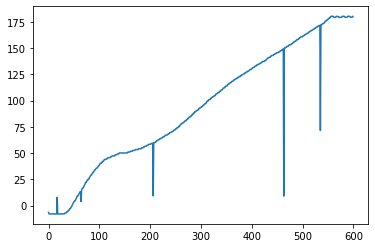

In [43]:
ydata=df['Filtered_pressure']
xdata=df['angle']
zdata=df['set_point']
ydata=ydata
xdata=xdata
pylab.plot(xdata, label='data')